# Deep Learning for NLP - Exercise 01
Building, Tuning and Evaluating a standard RNN Model

General hints:
* Have a look at the imports below when solving the tasks
* Use the given modules and all submodules of the imports, but don't import anything else!
    * For instance, you can use other functions under the `torch` or `nn` namespace, but don't import e.g. PyTorch Lightning, etc.
* It is recommended to install all packages from the provided environment file
* Feel free to test your code between sub-tasks of the exercise sheet, so that you can spot mistakes early (wrong shapes, impossible numbers, NaNs, ...)
* Just keep in mind that your final submission should be compliant to the provided initial format of this file

Submission guidelines:
* Make sure that the code runs on package versions from the the provided environment file
* Do not add or change any imports (also don't change the naming of imports, e.g. `torch.nn.functional as f`)
* Remove your personal, additional code testings and experiments throughout the notebook
* Do not change the class, function or naming structure as we will run tests on the given names
* Additionally export this notebook as a `.py` file, and submit **both** the executed `.ipynb` notebook with plots in it **and** the `.py` file
* **Deviation from the above guidelines will result in partial or full loss of points**

If you are using Google Colab or similar services, make sure to install all necessary packages so that the import cell below is working.

Usually, you would need to `!pip install`:
```
!pip install datasets==3.0.1
!pip install spacy==3.6.1
!pip install torch==2.0.1    # just to be sure we are all working with the same version
!pip install torchtext==0.15.2
!python -m spacy download en_core_web_sm
```

Make sure to comment out the lines before submitting!

In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Sampler, BatchSampler, Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

from datasets import load_dataset

In [2]:
def regularized_f1(train_f1, dev_f1, threshold=0.0015):
    """
    Returns development F1 if overfitting is below threshold, otherwise 0.
    """
    return dev_f1 if (train_f1 - dev_f1) < threshold else 0


def save_metrics(*args, path, fname):
    if not os.path.exists(path):
        os.makedirs(path)
    if not os.path.isfile(path + fname):
        with open(path + fname, "w", newline="\n") as f:
            f.write(
                ",".join(
                    [
                        "config",
                        "epoch",
                        "train_loss",
                        "train_acc",
                        "train_f1",
                        "val_loss",
                        "val_acc",
                        "val_f1",
                    ]
                )
            )
            f.write("\n")
    if args:
        with open(path + fname, "a", newline="\n") as f:
            f.write(",".join([str(arg) for arg in args]))
            f.write("\n")

def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(1234)

In [3]:
VOCAB_SIZE = 20_000
BATCH_SIZE = 32
NUM_EPOCHS = 15
MAX_LEN = 256
LEARNING_RATE = 1e-4

## Task 1 - Download and prepare the dataset
- Load the train and test set of IMDB (it is included in the `datasets` module we imported above)
- Split the train set into train and validation set
    * Train set should consist of the middle 10% to 85% of data
    * Validation set should be the two remaining ends
    * You can achieve this slicing directly within the `load_dataset` function, check out the [Huggingface slicing API](https://huggingface.co/docs/datasets/v2.13.1/loading#slice-splits)
- Test set should stay unchanged

In [4]:
# Loading the dataset with slicing
train_data = load_dataset("imdb", split="train[10%:85%]")
dev_data = load_dataset("imdb", split="train[:10%]+train[85%:]")
test_data = load_dataset("imdb", split="test")

* Define the tokenizer using `get_tokenizer` with spacy's `en_core_web_sm` module
    * You don't have to import spacy for that, but it is necessary to have spacy installed and the `en_core_web_sm` module downloaded
* Create the vocabulary using `build_vocab_from_iterator`
    * Think about which split(s) should be used to build the vocabulary
    * Include two special tokens: `'<UNK>'` at index `0`, `'<PAD>'` at index `1`
    * Limit the vocab size to `VOCAB_SIZE`, as defined in the beginning
    * Set the vocab's default returning index to `0` by making the `'<UNK>'` token default
    
Hint:
* This might be a good moment to add a personal test to check whether your vocab actually returns `0` for an unknown input token

In [6]:
# Tokenizer
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")

# Vocabulary
vocab = build_vocab_from_iterator(
    (tokenizer(text["text"]) for text in train_data),
    specials=["<UNK>", "<PAD>"],  
    max_tokens=VOCAB_SIZE
)

# Setting the default to 0
vocab.set_default_index(vocab["<UNK>"])

* Use the tokenizer and vocabulary to turn your three data splits into indices
* Limit the maximum tokenized sequence length to `MAX_LEN`

**Note**:
In practice, performing this step on its own during the preprocessing stage is usually not feasible due to the memory constraints associated with storing large datasets. Consequently, the tokenization and indexing steps are typically performed "on the fly" within the `DataLoader`, specifically in the `collate_batch` step.

In [7]:
train_idx = [[vocab[token] for token in tokenizer(text["text"])[:MAX_LEN]] for text in train_data]
dev_idx = [[vocab[token] for token in tokenizer(text["text"])[:MAX_LEN]] for text in dev_data]
test_idx = [[vocab[token] for token in tokenizer(text["text"])[:MAX_LEN]] for text in test_data]

* Define a torch dataset by inhereting from `Dataset`
* It should create the building block to return the tokenized indices and labels for a given index
* Instantiate it

In [8]:
class ImdbDataset(Dataset):
    def __init__(self, seq, lbl):
        self.seq = seq
        self.lbl = lbl

    def __getitem__(self, idx):
        return self.seq[idx], self.lbl[idx]

    def __len__(self):
        return len(self.seq)

In [9]:
train_set = ImdbDataset(train_idx, train_data["label"])

* Having batches in which samples have a similar length, and thus less padding variations, improves training results
* A `GroupedSampler` allows us to create a sampler with which we can customize the data loading process
* It can then be implemented into the `DataLoader`, which automates loading data in multiple processes
* Write a sampler which allows us to group together samples of similar length into a batch
    * The `GroupedSampler` takes as input the tokenized sequences from `ImdbDataset`, as well as the batch size
    * First, in the `__init__` method, pair each sequence index with its tokenized sequence length
        * The result should be a list of tuples: `[(index, tokenized_sequence_length), ...]`
    * In the `__iter__` method, we now:
        * Shuffle the list
        * generate groups of size `BATCH_SIZE * 100`
        * Each group of size `BATCH_SIZE * 100` should be sorted in itself by the sequence length we calculated above
            * Sorting within each group is important because sorting based on the whole dataset would eliminate all training input variations
            * By shuffling in the `__iter__` method, we shuffle the set of indices in each new iteration (which equals an epoch), therefore, we keep input variation
        * The result should be a list of tuples sorted by ascending sequence length: `[(index, tokenized_sequence_length), ...]`
        * After each `BATCH_SIZE * 100` number of tuples, the sequence length of samples should drop and increase again
        * Example:
            ```
            Sample index 3199: (1234, 256)
            Sample index 3200: (567, 32)
            Sample index 3201: (890, 33)
            ```
        * Filter the created and sorted list to only consist of indices. Make sure to keep the sorting!
        * Return this list as an iterator
    * Complete the `__len__` method

In [10]:
class GroupedSampler(Sampler):
    def __init__(self, seqs, batch_size):
        self.batch_size = batch_size
        self.index_length_pairs = [(idx, len(seq)) for idx, seq in enumerate(seqs)]

    def __iter__(self):
        # Shuffling at the start of each epoch
        random.shuffle(self.index_length_pairs)
        
        # Splitting the list into groups of BATCH_SIZE * 100 for localized sorting by length
        grouped_batches = []
        for i in range(0, len(self.index_length_pairs), self.batch_size * 100):
            # Group of BATCH_SIZE * 100
            group = self.index_length_pairs[i:i + self.batch_size * 100]
            
            # Sorting each group by sequence length
            sorted_group = sorted(group, key=lambda x: x[1]) 
            
            # Adding only the indices in sorted order
            grouped_batches.extend([idx for idx, length in sorted_group])
        
        return iter(grouped_batches)

    def __len__(self):
        # Returns the total number of batches
        return (len(self.index_length_pairs) + self.batch_size - 1) // self.batch_size  

* Now create the `GroupedSampler`, use it as input to create a `BatchSampler` (imported in the beginning)

In [11]:
train_grouped_sampler = GroupedSampler(train_idx, BATCH_SIZE)
train_sampler = BatchSampler(train_grouped_sampler, batch_size=BATCH_SIZE, drop_last=False)

* Define a collate function which takes in a `batch` of tokenized sequences and labels created by the `BatchSampler`
    * Make sure to understand the structure of an input `batch`. Test around a bit to see what exactly they return.
* The collate function then:
    * pads these indices to the same length
        * use `padding_value=1`, `0` should be reserved for `UNK` token
    * turns the labels into tensors
    * finally, it creates a tensor which stores the length of all tokenized sentences **before** padding
    * the function should return 3 batched tensors: sequences, labels, lengths

In [12]:
# define collate function
def collate_batch(batch):
    # Separating tokenized sequences and labels from the batch
    seqncs, labels = zip(*batch)

    lengths = torch.tensor([len(seq) for seq in seqncs])

    sequences = pad_sequence([torch.tensor(seq) for seq in seqncs], 
                             batch_first=True, 
                             padding_value=1)

    labels = torch.tensor(labels)

    
    return sequences, labels, lengths

* Now create the final `DataLoader` for the train set
    * For your training, set the number of workers to your liking/cpu cores setup
    * When submitting this exercise, please set `num_workers=2` at maximum
* Repeat the `DataLoader` creation process for the validation and test set
    * It is not necessary to introduce randomness into the validation and test set
    * Create an `ImdbDataset` and `DataLoader` instance
    * leave `shuffle` off and don't include any Samplers
    * still include the correct batch size and collate function

In [20]:
# create dataloaders
train_loader = DataLoader(
    train_set,                 
    batch_size=BATCH_SIZE,          
    collate_fn=collate_batch,        
    num_workers=0,                   
    shuffle=True                     
)

dev_set = ImdbDataset(dev_idx, dev_data["label"])
test_set = ImdbDataset(test_idx, test_data["label"])

dev_loader = DataLoader(
    dev_set,
    batch_size=BATCH_SIZE,
    collate_fn=collate_batch,
    num_workers=0,
    shuffle=False
)

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    collate_fn=collate_batch,
    num_workers=0,
    shuffle=False
)

## Task 2 - Build Your Model
The model should consist of:
- an **embedding layer**, which takes `vocab_size` and `embedding_dim` as parameters
- a **dropout layer**, which takes `dropout` as a parameter
- an **LSTM layer**, which takes `embedding_dim` and `rnn_size` as parameters, and is bidirectional
- a **linear layer**, which takes the dimension of rnn output as input dimension and returns an output of `hidden_size` dimensions
- a **linear layer**, which first takes the previous layers output as input and returns one prediction per class of the dataset
- the output of the BiLSTM has hidden representation tensors for each index of each sequence. However, for the task of sequence classification, we just need one hidden representation tensor per sequence. Use `torch.mean()` as a pooling function for dimensionality reduction.
- use **dropout** on the embeddings and appropriate linear layer
- use **ReLU** as the activation function on the appropriate linear layer

_Hints:_
  - keep the position of the batch dimension equal across all layers
  - _use `pack_padded_sequence`_ and `pad_packed_sequence` at the appropriate steps. For more information, check out [this answer on stackoverflow](https://stackoverflow.com/a/56211056)
  - remember to include the `padding_idx=1` at relevant positions
  - as this is a binary classification task, it is possible to have 1 or 2 output neurons. Use your preference, but adjust the loss function towards your choice

In [14]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, rnn_size, hidden_size, dropout):
        super().__init__()
        # Embedding layer with padding index
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Bidirectional LSTM layer
        self.lstm = nn.LSTM(embedding_dim, rnn_size, bidirectional=True, batch_first=True)
        
        # First linear layer
        self.linear1 = nn.Linear(rnn_size * 2, hidden_size)
        
        # Output linear layer for binary classification
        self.output = nn.Linear(hidden_size, 1)


    def forward(self, seq, lengths):
        # Embedding & dropout
        embedded = self.embedding(seq)
        embedded = self.dropout(embedded)
        
        # Pack padded sequence
        packed_embedded = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        
        # Padding the packed output back to padded sequences
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        # Applying mean pooling across the sequence length dimension
        pooled_output = torch.mean(output, dim=1)
        
        # First linear layer with ReLU activation and dropout
        linear1_output = F.relu(self.linear1(pooled_output))
        linear1_output = self.dropout(linear1_output)
        
        # Final output layer
        output = self.output(linear1_output)

        # Returns squeezed output for binary classification
        return output.squeeze(1)

## Task 3 - Inner train loop
* Create a global `device` variable which checks whether a GPU is available or not, and sets the device to either GPU or CPU.

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

* Write the inner train/test loop by completing the function `process`.
    * It takes the model, a dataloader, criterion and optionally the optimizer
    * The function iterates once through the dataloader, i.e. one epoch
    * Include the `tqdm` functionality for the loop through the dataloader by placing the loader inside `tqdm()`
        * Print its output to `file=sys.stdout`, and use `'batches'` as unit
        * You can also add a `desc='...'` to get a marking whether we currently train or evaluate
    * The function also moves the sequences and labels to `device`
    * The `lengths` need to stay on CPU!
    * If the optimizer is given, training with backpropagation is performed, then the below defined metrics are returned
    * If the optimizer is missing, evaluation is performed and the below described metrics are calculated
    * Values to be calculated:
        * Loss, Accuracy, both as averages of the total number of samples per epoch
        * F1 score between all predictions and labels of the epoch

In [29]:
def process(model, loader, criterion, optim=None):
    model.to(device)
    is_train = optim is not None  # True if in training mode, False for evaluation

    if is_train:
        model.train()
    else:
        model.eval()

    total_loss = 0
    correct = 0
    total_samples = 0
    all_predictions = []
    all_labels = []

    # Progress bar setup
    with tqdm(loader, file=sys.stdout, unit='batches', desc="Training" if is_train else "Evaluating") as pbar:
        for sequences, labels, lengths in pbar:
            # Moving data to device
            sequences = sequences.to(device)
            labels = labels.to(device).float()  # Convert labels to float for BCEWithLogitsLoss, does not accept 'long' format
            lengths = lengths.cpu()  # Keeping lengths on CPU for sorting

            # Forward pass
            with torch.set_grad_enabled(is_train):
                outputs = model(sequences, lengths)
                loss = criterion(outputs, labels)

                if is_train:
                    # Backpropagation if in training mode
                    optim.zero_grad()
                    loss.backward()
                    optim.step()

            # Metrics calculations post-backpropagation
            total_loss += loss.item() * labels.size(0)  # Accumulate loss
            predictions = torch.round(torch.sigmoid(outputs))  # Binary predictions for accuracy
            correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

            # Detaching before converting to numpy to avoid tracking gradients
            all_predictions.extend(predictions.cpu().detach().numpy())
            all_labels.extend(labels.cpu().detach().numpy())

            # Progress bar update with current batch metrics
            pbar.set_postfix(loss=loss.item(), accuracy=correct / total_samples)

    # Calculating final metrics across the entire dataset
    avg_loss = total_loss / total_samples
    accuracy = correct / total_samples
    f1 = f1_score(all_labels, all_predictions, average="binary")  # Binary F1 score

    return avg_loss, accuracy, f1


# Task 4 - Training and Hyperparameter Optimization
In the following, we provide 3 configurations for the above created BiLSTM. Try to understand how they differ from each other.

In [30]:
configs = {
    "config1": {
        "vocab_size": VOCAB_SIZE,
        "embedding_dim": 10,
        "hidden_size": 10,
        "rnn_size": 10,
        "dropout": 0.5
    },
    "config2": {
        "vocab_size": VOCAB_SIZE,
        "embedding_dim": 64,
        "hidden_size": 32,
        "rnn_size": 256,
        "dropout": 0.5
    },
    "config3": {
        "vocab_size": VOCAB_SIZE,
        "embedding_dim": 300,
        "hidden_size": 256,
        "rnn_size": 256,
        "dropout": 0.5
    }

}

* Choose the correct criterion to train and evaluate your created model

In [31]:
criterion = nn.BCEWithLogitsLoss()

Use the given functions `regularized_f1` and `save_metrics` from the start of the notebook to implement the hyperparameter search and training runs.

Specifically:
* Iterate through each configuration
* Create and re-create the model for each new configuration run
    * Move the model to the `device`
* Create and re-create the optimizer with each new configuration model's paramaters
    * Use Adam as the optimizer
    * Use the learning rate defined at the beginning of notebook
* Train each configuration for `NUM_EPOCHS` epochs
* Change the model into train and evaluation mode at appropriate times
* Stop gradient calculation for evaluation runs
* Save metrics after each train and evaluation runs.
    * Have a look at the function to see what the expected inputs are
    * In the `.csv` file, only numbers should be entered
    * For instance, the inputs for the columns `config` and `epoch` should be e.g. `1`, _not_ `config1` or `epoch1`
* Optional: Print training progress for your own information

In order to check whether our model generalizes or just 'remembers', we need to compare the model's performance on the train set to the performance on the validation set. As we are only interested in non-overfitting performances, we only want to save model checkpoints when the model actually generalizes, i.e. has a higher F1 score on the validation set than on the train set.
* Calculate the regularized f1 score using the given function
* Keep track of multiple values during training:
    * Save the overall (i.e. across all configs *and* epochs) highest validation F1 score
        * Save your best model parameters
        * Overwrite your model parameters every time your model fulfills both the `regularized_f1` criteria and is better than the previous overall highest F1 score
        * In the end, the last saved `best_model.pt` parameters are automatically the best
        * Hint: Keep track (e.g. by printing or in a variable), which config produced the best model, so you can directly load that config for the test set run.
    * Track the highest F1 score inside a configuration but across epochs
        * Implement early-stopping for a configuration run if 3 consecutive epochs are below the highest F1 score for the current configuration

In [32]:
path = './'
logging_file = 'results.csv'

best_f1_overall = 0
best_model_state = None

# Iterating through configurations
for config_num, config in enumerate(configs.values(), 1):
    # Creating a new model with the current configuration
    model = BiLSTM(
        vocab_size=config["vocab_size"],
        embedding_dim=config["embedding_dim"],
        rnn_size=config["rnn_size"],
        hidden_size=config["hidden_size"],
        dropout=config["dropout"]
    ).to(device)
    
    # Defining Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Initializing variables for tracking the highest F1 in the current configuration
    best_f1_config = 0
    epochs_without_improvement = 0
    
    for epoch in range(1, NUM_EPOCHS + 1):
        # Training Phase
        model.train()
        train_loss, train_acc, train_f1 = process(model, train_loader, criterion, optimizer)
        
        # Evaluation Phase
        model.eval()
        with torch.no_grad():
            val_loss, val_acc, val_f1 = process(model, dev_loader, criterion)
        
        # Checking for overfitting using regularized F1
        reg_f1 = regularized_f1(train_f1, val_f1)
        
        # Saving metrics for the current epoch
        save_metrics(
            config_num, epoch, train_loss, train_acc, train_f1,
            val_loss, val_acc, val_f1, path=path, fname=logging_file
        )
        
        # Checking if this is the best model so far in all configurations
        if reg_f1 > 0 and val_f1 > best_f1_overall:
            best_f1_overall = val_f1
            best_model_state = model.state_dict()
        
        # Updating the best F1 for the current configuration and checking for early stopping
        if val_f1 > best_f1_config:
            best_f1_config = val_f1
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        # Early stopping for 3 epochs
        if epochs_without_improvement >= 3:
            print(f"Early stopping triggered for config {config_num} at epoch {epoch}")
            break

# Saving the best model
if best_model_state is not None:
    torch.save(best_model_state, path + 'best_model.pt')
print("Training and hyperparameter search complete.")

Training: 100%|█| 586/586 [01:02<00:00,  9.45batches/s, accuracy=0.485, loss=0.7
Evaluating: 100%|█| 196/196 [00:04<00:00, 47.30batches/s, accuracy=0.57, loss=0.
Training: 100%|█| 586/586 [01:02<00:00,  9.30batches/s, accuracy=0.497, loss=0.6
Evaluating: 100%|█| 196/196 [00:04<00:00, 48.62batches/s, accuracy=0.432, loss=0
Training: 100%|█| 586/586 [01:01<00:00,  9.49batches/s, accuracy=0.506, loss=0.6
Evaluating: 100%|█| 196/196 [00:03<00:00, 49.35batches/s, accuracy=0.421, loss=0
Training: 100%|█| 586/586 [01:03<00:00,  9.24batches/s, accuracy=0.522, loss=0.7
Evaluating: 100%|█| 196/196 [00:04<00:00, 46.96batches/s, accuracy=0.413, loss=0
Early stopping triggered for config 1 at epoch 4
Training: 100%|█| 586/586 [37:38<00:00,  3.85s/batches, accuracy=0.563, loss=0.6
Evaluating: 100%|█| 196/196 [00:18<00:00, 10.76batches/s, accuracy=0.61, loss=0.
Training: 100%|█| 586/586 [2:49:28<00:00, 17.35s/batches, accuracy=0.627, loss=0
Evaluating: 100%|█| 196/196 [01:09<00:00,  2.82batches/s, ac

* Load in the created `results.csv` file
* Create 6 plots: 3 rows with each 2 sub-plots
* Each row of plots should correspond to a configuration
* Each left plot shows the loss progression per epoch
    * Include both train and evaluation progress in the same plot, but plot the evaluation lines dashed
    * Plot losses in blue
* Each right plot shows both the accuracy and F1 progression per epoch
    * Include both train and evaluation progess in the same plot, but plot the evaluation lines dashed
    * Plot accuracy in orange, and plot F1 in green
* Have a look at the example plot file included with this exercise. It constitutes one row of the plot.
* After plotting, briefly describe what problems and successes you see with each configuration

**Here you can see a partial example plot**
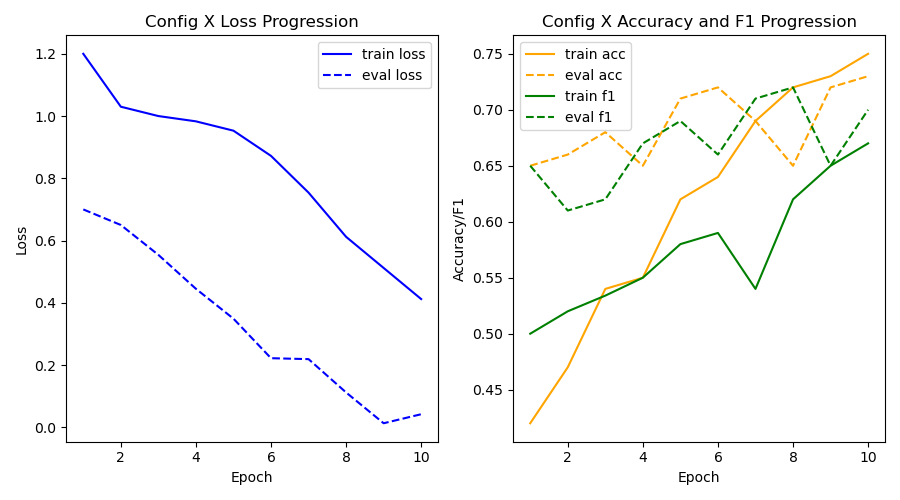


In [33]:
df = pd.read_csv('results.csv')

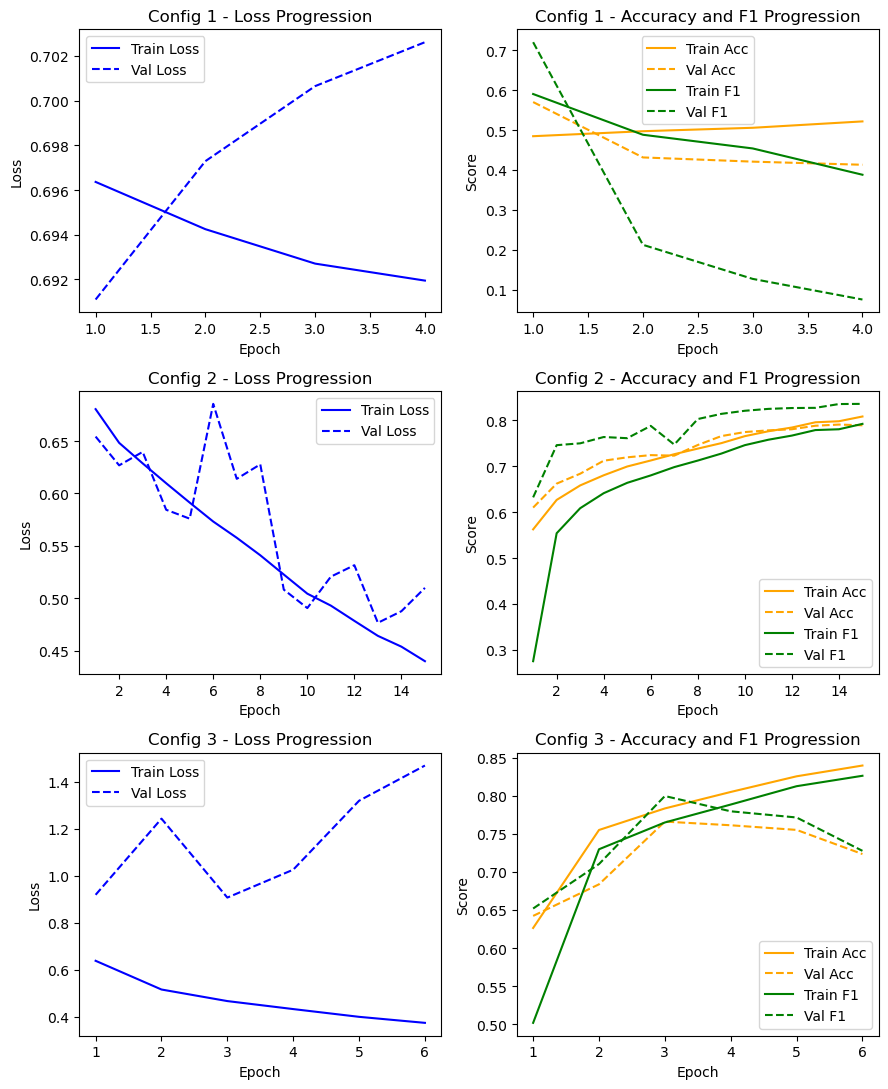

In [34]:
fig, ax = plt.subplots(3, 2, figsize=(9, 11))

# Iterating over each configuration
for config_num in range(1, 4):
    config_data = df[df['config'] == config_num]

    # Extracting metrics
    epochs = config_data['epoch']
    train_loss = config_data['train_loss']
    val_loss = config_data['val_loss']
    train_acc = config_data['train_acc']
    val_acc = config_data['val_acc']
    train_f1 = config_data['train_f1']
    val_f1 = config_data['val_f1']

    # Plot of loss progression
    ax[config_num-1, 0].plot(epochs, train_loss, label='Train Loss', color='blue')
    ax[config_num-1, 0].plot(epochs, val_loss, label='Val Loss', color='blue', linestyle='--')
    ax[config_num-1, 0].set_title(f'Config {config_num} - Loss Progression')
    ax[config_num-1, 0].set_xlabel('Epoch')
    ax[config_num-1, 0].set_ylabel('Loss')
    ax[config_num-1, 0].legend()

    # Plot of accuracy and F1 progression
    ax[config_num-1, 1].plot(epochs, train_acc, label='Train Acc', color='orange')
    ax[config_num-1, 1].plot(epochs, val_acc, label='Val Acc', color='orange', linestyle='--')
    ax[config_num-1, 1].plot(epochs, train_f1, label='Train F1', color='green')
    ax[config_num-1, 1].plot(epochs, val_f1, label='Val F1', color='green', linestyle='--')
    ax[config_num-1, 1].set_title(f'Config {config_num} - Accuracy and F1 Progression')
    ax[config_num-1, 1].set_xlabel('Epoch')
    ax[config_num-1, 1].set_ylabel('Score')
    ax[config_num-1, 1].legend()


plt.tight_layout()
plt.show()

___

Student answer here: 

# Inferring the Plots for Each Configuration


## Configuration 1
    With the config1, it's clearly seen in the Loss Progression plot that Validation Loss steadily increases while Training Loss decreases. Validation Loss surpasses Traning Loss at the second epoch, indicating that the model's generalization ability does not perform at the desired levels. Looking at config1's F1 score and accuracy, the results from the Loss Progression are confirmed as the F1 score of the Evaluation Set drops below the Training Set's F1 score at the second epoch, decreasing consistently with each number of epochs. Additionally, accuracy follows a similar trend for config1. 
    
## Configuration 2    
    In the Loss Progression plot for Config 2, we observe a consistent downward trend in both Training and Validation Loss, indicating that the model is improving its fit on the data over time. However, the Validation Loss fluctuates slightly but remains generally lower than the Training Loss throughout the epochs, suggesting better generalization than Config 1. The F1 score and accuracy plots corroborate this finding; both metrics increase steadily for both the Training and Validation sets. Importantly, the Validation F1 score remains close to the Training F1 score without showing significant divergence, indicating balanced performance on unseen data. This suggests that Config 2 offers a more stable and effective model with improved generalization compared to Config 1.
    
## Configuration 3    
    For Config 3, the Loss Progression plot reveals an initial sharp decrease in Training Loss, which stabilizes after a few epochs. However, the Validation Loss demonstrates a more erratic pattern, with frequent spikes, indicating that the model is struggling to generalize consistently. In the Accuracy and F1 progression plots, while the Training F1 score and accuracy show consistent improvement, the Validation F1 score and accuracy do not follow a clear upward trajectory. In fact, the Validation F1 score starts declining after a few epochs, suggesting overfitting to the Training data. This lack of stability in the Validation metrics indicates that Config 3 may be overly complex for the data, causing it to overfit rather than generalize effectively.
___

* As the final step, instantiate a model with the config of the best run
* Load the `state_dict`
* Evaluate it on the test set
    * Don't forget to actviate evaluation mode and deactivate gradient calculation
* Comment on the performance
    * Did it generalize well? Why? Why not?
    * What could be done to improve the performance even further?
        * Consider also the hyperparameters from the third cell and discuss potential tradeoffs.

In [35]:
# evaluate on test set
model = BiLSTM(
    vocab_size=VOCAB_SIZE,        # config2's hyperparameters
    embedding_dim=64,             
    rnn_size=256,                 
    hidden_size=32,               
    dropout=0.5                   
).to(device)

# Load the saved best model weights
model.load_state_dict(torch.load(path + 'best_model.pt'))

# Set model to evaluation mode and disable gradient calculations for evaluation
model.eval()
with torch.no_grad():
    test_loss, test_acc, test_f1 = process(model, test_loader, criterion)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

Evaluating: 100%|█| 782/782 [01:19<00:00,  9.79batches/s, accuracy=0.789, loss=0
Test Loss: 0.4864
Test Accuracy: 0.7886
Test F1 Score: 0.8090


___

Student answer here:

# Performance and Generalization

    The test results indicate that the model has generalized fairly well,

#### Test Loss of 0.4864

    Which is reasonable and not significantly higher than the validation loss seen in earlier runs.

#### Test Accuracy of 78.86% 

    Which shows that the model correctly classified a significant portion of the test data.

#### Test F1 Score of 80.90%

    Which is especially promising as it’s a good indicator of balanced precision and recall, reflecting the model's effectiveness in handling both classes in the binary classification task.

    The close alignment between the test F1 score and validation F1 score implies that the model has generalized without overfitting to the training data. This balanced performance suggests that the model’s configuration and regularization strategies (Dropout & Early Stopping) have helped it generalize well beyond the training set.

# Further Improvements on the Performance

## Hyperparameter Tuning:

#### Embedding Dim and RNN Size

    Experimenting with larger or smaller embedding dimensions or RNN sizes could capture more semantic information from the text. However, increasing these can lead to longer training times and a higher risk of overfitting.
    
#### Batch Size and Learning Rate

    Using a larger batch size might stabilize training, but it would require more memory. Additionally, adjusting the learning rate, somehow dynamically, can help with convergence.

## Additional Regularization:

    Applying a slightly higher dropout rate might help with further regularization. Though early stopping was already implemented, tuning it for fewer or more (for config2) patience epochs could yield a better fit.

## More Complex Architectures:

    Attention Mechanisms: Adding an attention layer could allow the model to focus on the most relevant parts of each sequence, it could potentially improve classification by better capturing long-range dependencies.


# Tradeoffs of the Mentioned Improvements & Comparison with Configuration 3

    These suggested improvements have potential tradeoffs:

## Training Time

    Increasing embedding dimensions, hidden dimensions or adding attention layers would lead to longer training times and higher computational costs. Dramatically increasing the hidden_size and embedding_dim hyperparameters as in configuration 3 would be an example of this tradeoff (with significantly worse generalization performance as well.)
    
## Risk of Overfitting

    With a more complex model (like a transformer), there’s a risk of overfitting, especially if the training dataset is not large enough. However, our dataset is rich enough for a transformer model to work well. 
    
## Memory Constraints

    A larger batch size or complex models will require more memory, which might not be feasible on some devices.
    
___